# DSHARP opacities (RADMC-3D)
| Author  | Stanley A. Baronett  |
|---------|----------------------|
| Created |  04/06/2024          |
| Updated |  10/22/2024          |

## Stellar Properties

The luminosity $L = FA$, where $F$ is the flux and $A$ is the emission surface area.
For an emitting sphere with radius $R$, and $F = ca_\mathrm{r}T^4/4$ (Rybicki & Lightman 1979, eq. 1.43), where $ca_\mathrm{r}/4 = \sigma$ the Stefan–Boltzmann constant $\left[\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-2}\,\mathrm{K}^{-4}\right]$

\begin{align}
  L &= \frac{ca_\mathrm{r}}{4} T^4(4\pi R^2) \\
    &= \pi ca_\mathrm{r} T^4R^2
\end{align}

In [1]:
#===============================================================================
import numpy as np

# BEGIN athinput.[pgen]
# <radiation>
length_unit      = 5.98e14             # L_0 [cm]
T_unit           = 6.14e3              # T_0 [K]
density_unit     = 4.28e-14            # \rho_0 [g/cm^3]
molecular_weight = 0.6                 # \mu

# <problem>
R                = 1.16e-4             # solar radius [L_0]
T                = 9.42e-1             # solar temperature [T_0]
# END athinput.[pgen]

# Solar constants, astrophysical units and conversions
arad             = 7.565733250033928e-15 # radiation constant [erg/cm^3/K^4]
c_speed          = 2.99792458e10         # speed of light [cm/s]
Lsun             = 3.83e33               # solar luminosity [erg/s]
Rsun             = 6.95700e10            # solar radius [cm]
au               = 1.495978707e13        # astronomical unit [cm]
L_au             = length_unit/au        # [au]

# Compute stellar flux and luminosity
Flux = lambda r : np.power(T, 4)*np.power(R/r, 2)/4 # stellar flux at r [c*a_r*T_0^4]
A = 4*np.pi*(R*length_unit)**2                      # surface area [cm^2]
L = Flux(R)*c_speed*arad*T_unit**4*A                      # luminosity [erg/s]

print(f'       R = {R*length_unit/Rsun:.2f} Rsun')
print(f'       T = {T*T_unit:.0f} K')
print(f'       L = {L/Lsun:.2f} Lsun')
print(f'F( 1 au) = {Flux(1/L_au):.2e} ca_rT_0^4'\
      + f' = {Flux(1/L_au)*c_speed*arad*T_unit**4:.2e} erg/cm^2/s'\
      + f' = {Flux(1/L_au)*c_speed*arad*T_unit**4/1e3:.0f} W/m^2 (solar constant)')
print(f'F(10 au) = {Flux(10/L_au):.2e} ca_rT_0^4'\
      + f' = {Flux(10/L_au)*c_speed*arad*T_unit**4:.2e} erg/cm^2/s'\
      + f' = {Flux(10/L_au)*c_speed*arad*T_unit**4/1e3:.1f} W/m^2')
# Flux at Saturn (~10 au) https://astronomy.stackexchange.com/a/25242/33232

       R = 1.00 Rsun
       T = 5784 K
       L = 1.00 Lsun
F( 1 au) = 4.23e-06 ca_rT_0^4 = 1.36e+06 erg/cm^2/s = 1364 W/m^2 (solar constant)
F(10 au) = 4.23e-08 ca_rT_0^4 = 1.36e+04 erg/cm^2/s = 13.6 W/m^2


## Problem Setup

See [Desmos](https://www.desmos.com/) for interactive plots of 
- [$T = P/\rho$](https://www.desmos.com/calculator/ptyevuziu7)
- [$\rho_\mathrm{mid}$](https://www.desmos.com/calculator/ubtsqj1ltb)
- [$\rho(\theta)$](https://www.desmos.com/calculator/marlugmhhr)

In code units,
\begin{align*}
  T(r, \theta) &= \frac{P(r, \theta)}{\rho} = \frac{P_0}{\rho_0}\left(\frac{r\sin\theta}{r_0}\right)^{-1/2} \\
  \rho_\mathrm{mid}(r) &= \frac{\rho_0\left(\frac{r + r_0}{r_0}\right)^{-9/4}}{1 + \exp\left[-\mathrm{e}^\mathrm{e}\left(\frac{r - r_0}{r_0}\right)\right]} \\
  \rho(r, \theta) &= \rho_\mathrm{mid}\exp\left[\frac{GMr}{P}\left(\frac{1}{\sqrt{r^2\sin^2\theta + r^2\cos^2\theta}} - \frac{1}{r\sin\theta}\right)\right] \\
                  &= \rho_\mathrm{mid}\exp\left[\frac{GM}{P}\left(1 - \frac{1}{\sin\theta}\right)\right] \\
\end{align*}

Let $u_\mathrm{init}$ be the initial specific internal energy of the gas.
From the [classical ideal gas law](https://en.wikipedia.org/wiki/Equation_of_state#Classical_ideal_gas_law), in code units,

\begin{align*}
  T_\mathrm{init} &=  (\gamma - 1)u_\mathrm{init} \\
  u_\mathrm{init} &= \frac{P}{\rho(\gamma - 1)}
\end{align*}

h/r (r = L_0) = 0.06 (cf. original h/r_0 = 0.07)

/athinput.[pgen]
<problem>
...
kappa_a = 558.98169599999994  # absorption opacity [\rho_0*L_0]
kappa_a = 21.84 cm^2/g


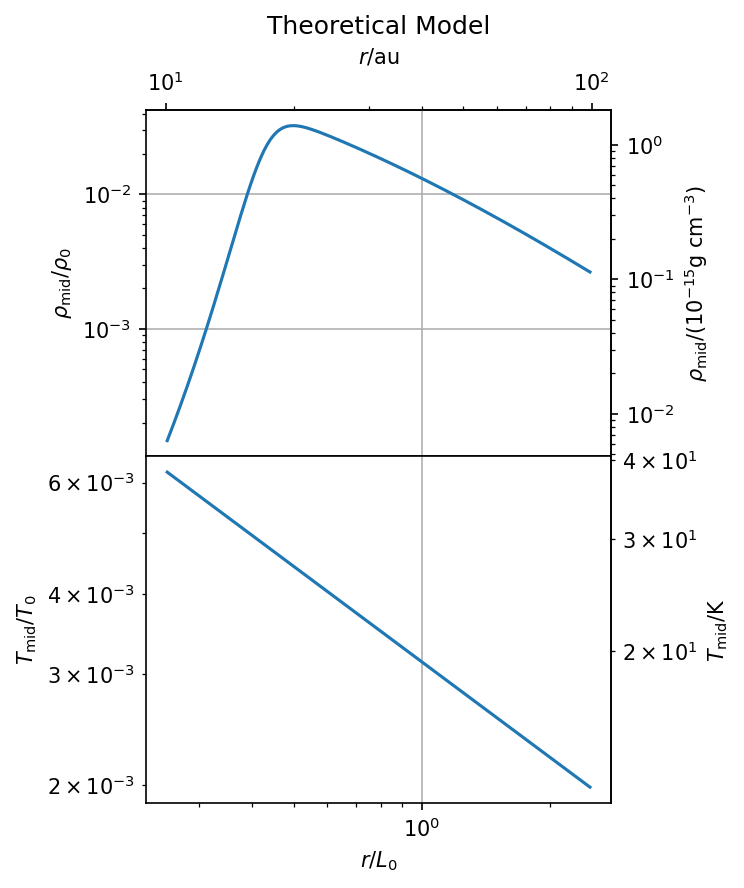

In [2]:
#===============================================================================
import numpy as np
import matplotlib.pyplot as plt

# BEGIN [pgen].cpp
# void Mesh::InitUserMeshData(ParameterInput *pin) {
# // Get parameters for gravitatonal potential of central point mass
gm0 = 1.0 # pin->GetOrAddReal("problem","GM",0.0);

# //---------------------------------------------------------------------------
# //! transform to cylindrical coordinate

def GetCylCoord(x1, x2, x3):
  rad = np.abs(x1*np.sin(x2))
  phi = x3
  z = x1*np.cos(x2)
  return rad, phi, z

# //---------------------------------------------------------------------------
# //! computes density in cylindrical coordinates

def DenProfileCyl(rad, phi, z):
  p_over_r = PoverR(rad, phi, z)
  denmid = rho0*np.power((rad + r0)/r0, dslope)\
           /(1 + np.exp(-np.exp(np.e)*(rad - r0)/r0))
  dentem = denmid*np.exp(gm0/p_over_r*(1./np.sqrt(rad**2 + z**2) - 1./rad))
  den = dentem
  return den

# //---------------------------------------------------------------------------
# //! computes pressure/density in cylindrical coordinates

def PoverR(rad, phi, z):
  poverr = p0_over_r0*np.power(rad/r0, pslope)
  return poverr
# END [pgen].cpp

# extra quantities
kappa_star_cgs    = 10                 # [cm^2/g]
dgratio           = 100                # dust-to-gas ratio
small_grain_ratio = 0.02184

# begin athinput.[pgen]
# <mesh>
nx1              = 128                 # Number of zones in X1-direction
x1min            = 0.250163663377926   # minimum value of X1
x1max            = 2.501636633779264   # maximum value of X1

nx2              = 1024                # Number of zones in X2-direction
x2min            = 0                   # minimum value of X2
x2max            = 3.141592653589793   # maximum value of X2

# <hydro>
dfloor           = 1e-12               # minimum density

# <problem>
r0               = 0.425278227742474   # disk radial normalization [L_0]
rho0             = 0.2                 # disk density normalization [\rho_0]
p0_over_r0       = 4.80e-03            # (H/r0)^2
pslope           = -0.5                # pressure power-law index
dslope           = -2.25               # density power-law index
kappa_a          = 558.98169599999994  # absorption opacity [\rho_0*L_0]
# end athinput.[pgen]

# Compute dust opacity in code units
kappa_star = kappa_star_cgs*dgratio*small_grain_ratio*density_unit*length_unit
print(f'h/r (r = L_0) = {(PoverR(1, np.pi/2, 0))**0.5:.2f}'\
      + f' (cf. original h/r_0 = {p0_over_r0**0.5:.2f})\n')
print('/athinput.[pgen]\n<problem>\n...')
print(rf'kappa_a = {kappa_a:.14f}  # absorption opacity [\rho_0*L_0]')
print(rf'kappa_a = {kappa_a/density_unit/length_unit:.2f} cm^2/g')

# Conversions
rad2deg          = 180/np.pi           # [deg]

# Generate fields
x1f = np.logspace(np.log10(x1min), np.log10(x1max), nx1+1)
x2f = np.linspace(x2min, x2max, nx2+1)
x1v, x2v = (x1f[:-1] + x1f[1:])/2, (x2f[:-1] + x2f[1:])/2
x1mesh, x2mesh = np.meshgrid(x1v, x2v)
rads, phis, zs = GetCylCoord(x1mesh, x2mesh, 0)
rho_field_theo = DenProfileCyl(rads, phis, zs)
rho_field_theo[rho_field_theo < dfloor] = dfloor
T_field_theo = PoverR(rads, phis, zs)
dtheta_theo = (x2max - x2min)/nx2
theta_mid_deg = 90
j_mid = int(theta_mid_deg/rad2deg/dtheta_theo)

# Plot
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(4, 6), dpi=150)
axs[0].plot(x1v, rho_field_theo[j_mid, :])
axs[1].plot(x1v, T_field_theo[j_mid, :])

# Format secondary axes in cgs
def r2au(r):
  return r*L_au

def rho2cgs(rho):
  return rho*density_unit/1e-15

def T2cgs(T):
  return T*T_unit

ax_r = axs[0].secondary_xaxis('top', functions=(r2au, r2au))
ax_rho = axs[0].secondary_yaxis('right', functions=(rho2cgs, rho2cgs))
ax_T = axs[1].secondary_yaxis('right', functions=(T2cgs, T2cgs))

ax_r.set(xlabel=r'$r$/au')
ax_r.minorticks_on()
ax_rho.set(ylabel=r'$\rho_\mathrm{mid}$/($10^{-15}$g cm$^{-3}$)')
ax_rho.minorticks_on()
ax_T.set(ylabel=r'$T_\mathrm{mid}$/K')
ax_T.minorticks_on()

# Format subplots
for ax in axs:
  ax.set(xscale='log', yscale='log')
  ax.grid()
  ax.minorticks_on()

axs[0].set(title='Theoretical Model', ylabel=r'$\rho_\mathrm{mid}/\rho_0$')
axs[1].set(xlabel=r'$r/L_0$',
           ylabel=r'$T_\mathrm{mid}/T_0$')
plt.subplots_adjust(hspace=0.0)
# plt.savefig('figs/frame.jpg', bbox_inches='tight')

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

Reading amr_grid.inp
Reading wavelength_micron.inp
Reading dust_density.inp
Reading dustkappa_dsharp.inp
Opacity at 0.88um :  19233.939524821228


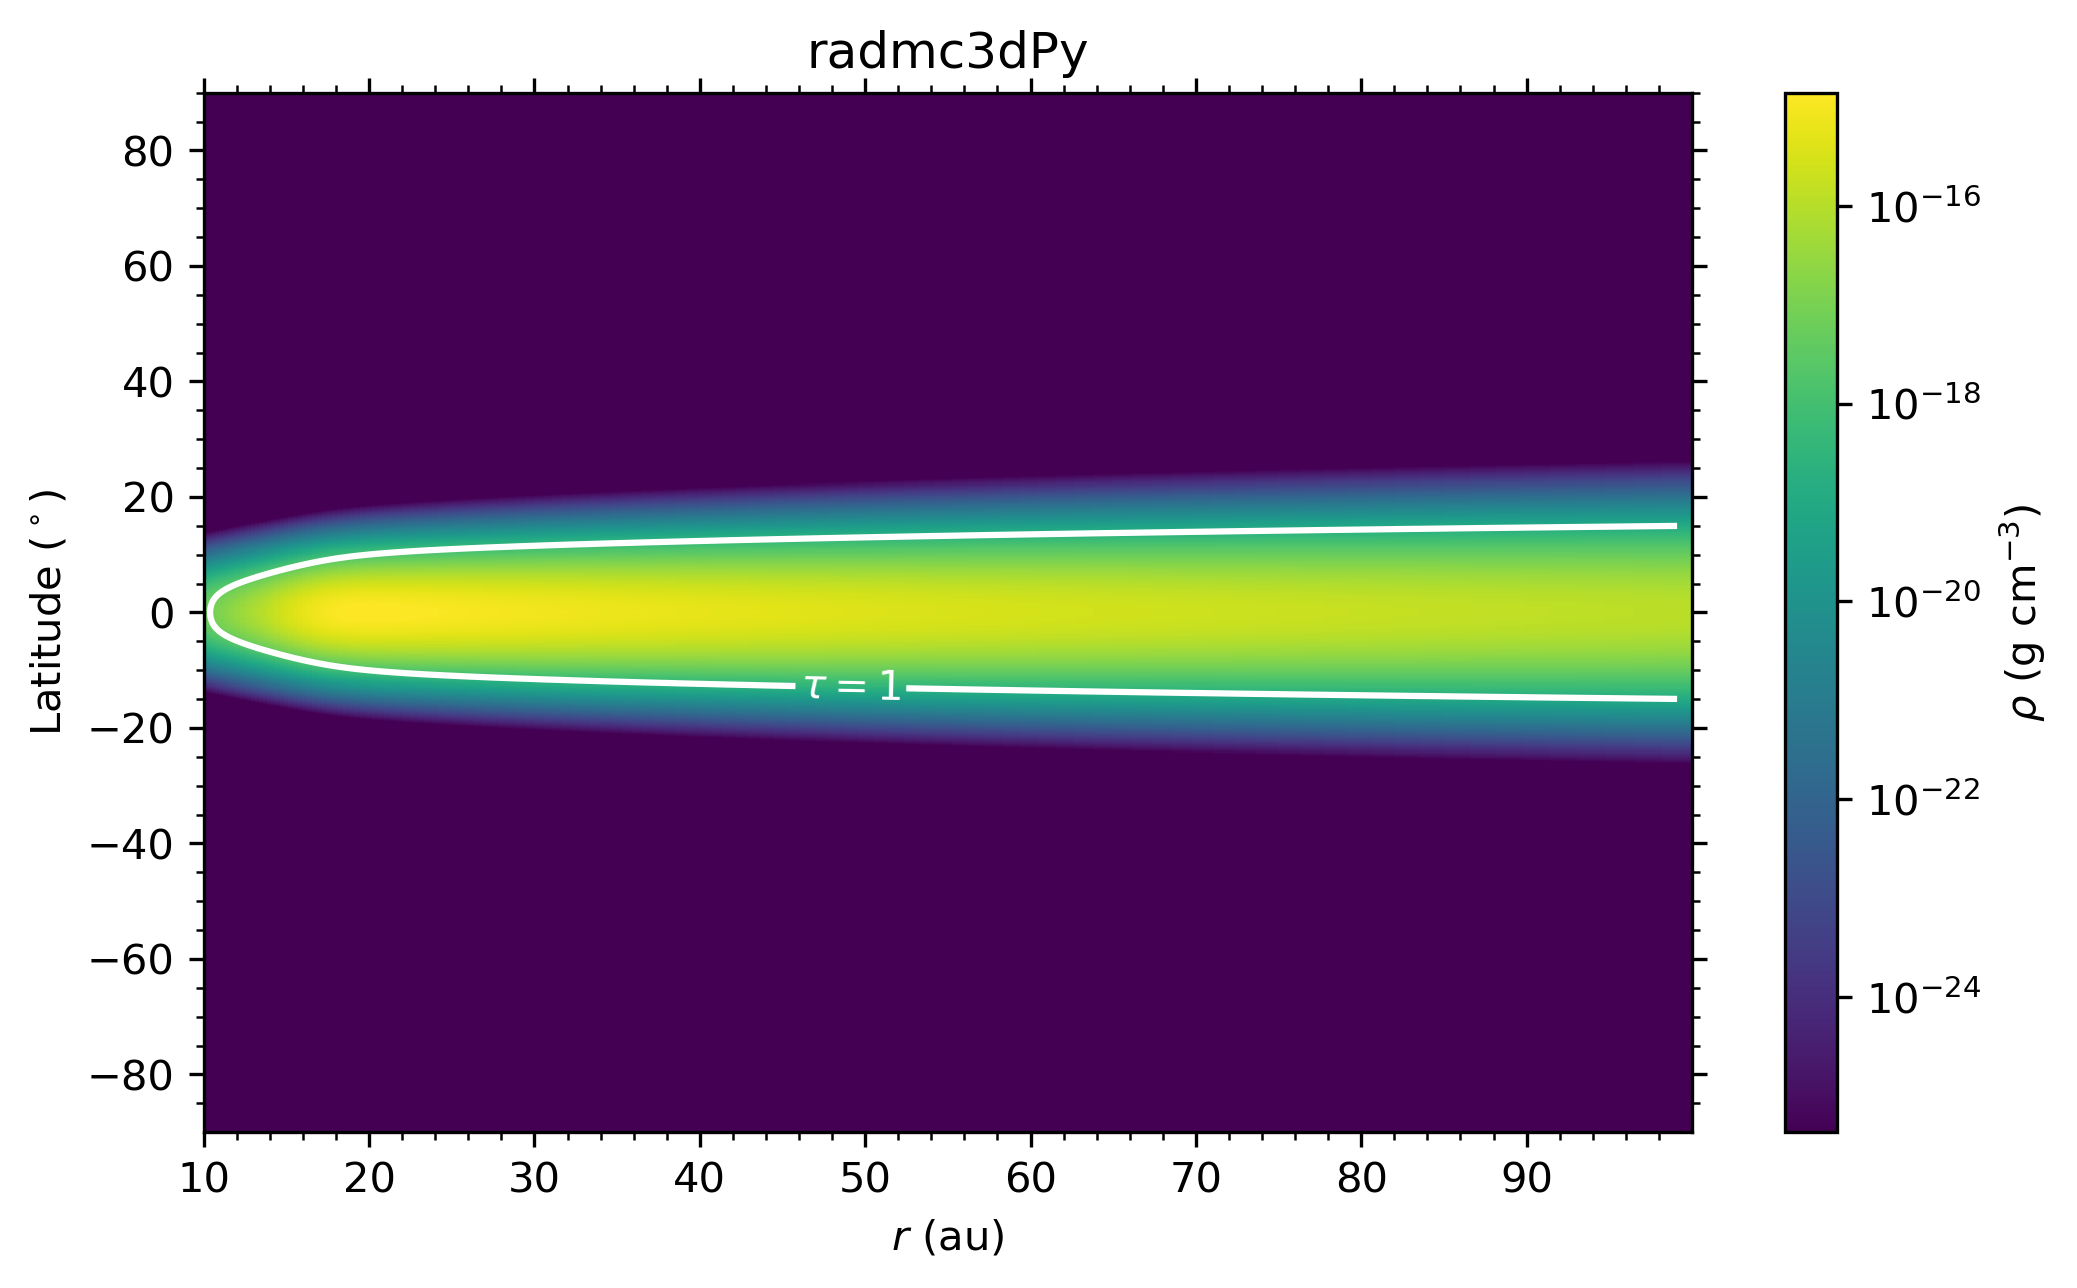

In [3]:
#===============================================================================
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
from radmc3dPy import *

# Conversions
rad2deg = 180/np.pi # [deg]

# Prepare plots
def fmt(x):
    return rf'$\tau={x:.0f}$'
fig, ax = plt.subplots(figsize=(8, 4.5), dpi=300)

# RADMC-3D
data = analyze.readData(ddens=True)
np.savez_compressed('dust_density', rhodust=data.rhodust)
im = ax.pcolormesh(data.grid.x/natconst.au, 90-data.grid.y*rad2deg,
                   data.rhodust[:,:,0,0].T, norm=colors.LogNorm())
data.getTau(wav=0.88)
CS = ax.contour(data.grid.x/natconst.au, 90-data.grid.y*rad2deg,
                data.taux[:,:,0].T, [1, 1e5], colors=['w', 'w'])

# Format (sub)plots
plt.colorbar(im, label=r'$\rho$ (g cm$^{-3}$)')
ax.clabel(CS, CS.levels, fmt=fmt)
ax.minorticks_on()
ax.set(xlabel='$r$ (au)', ylabel=r'Latitude ($^\circ$)',
       title='radmc3dPy')
ax.tick_params(axis='both', which='both', top=True, right=True)

Reading amr_grid.inp
Reading wavelength_micron.inp
Reading dust_density.inp


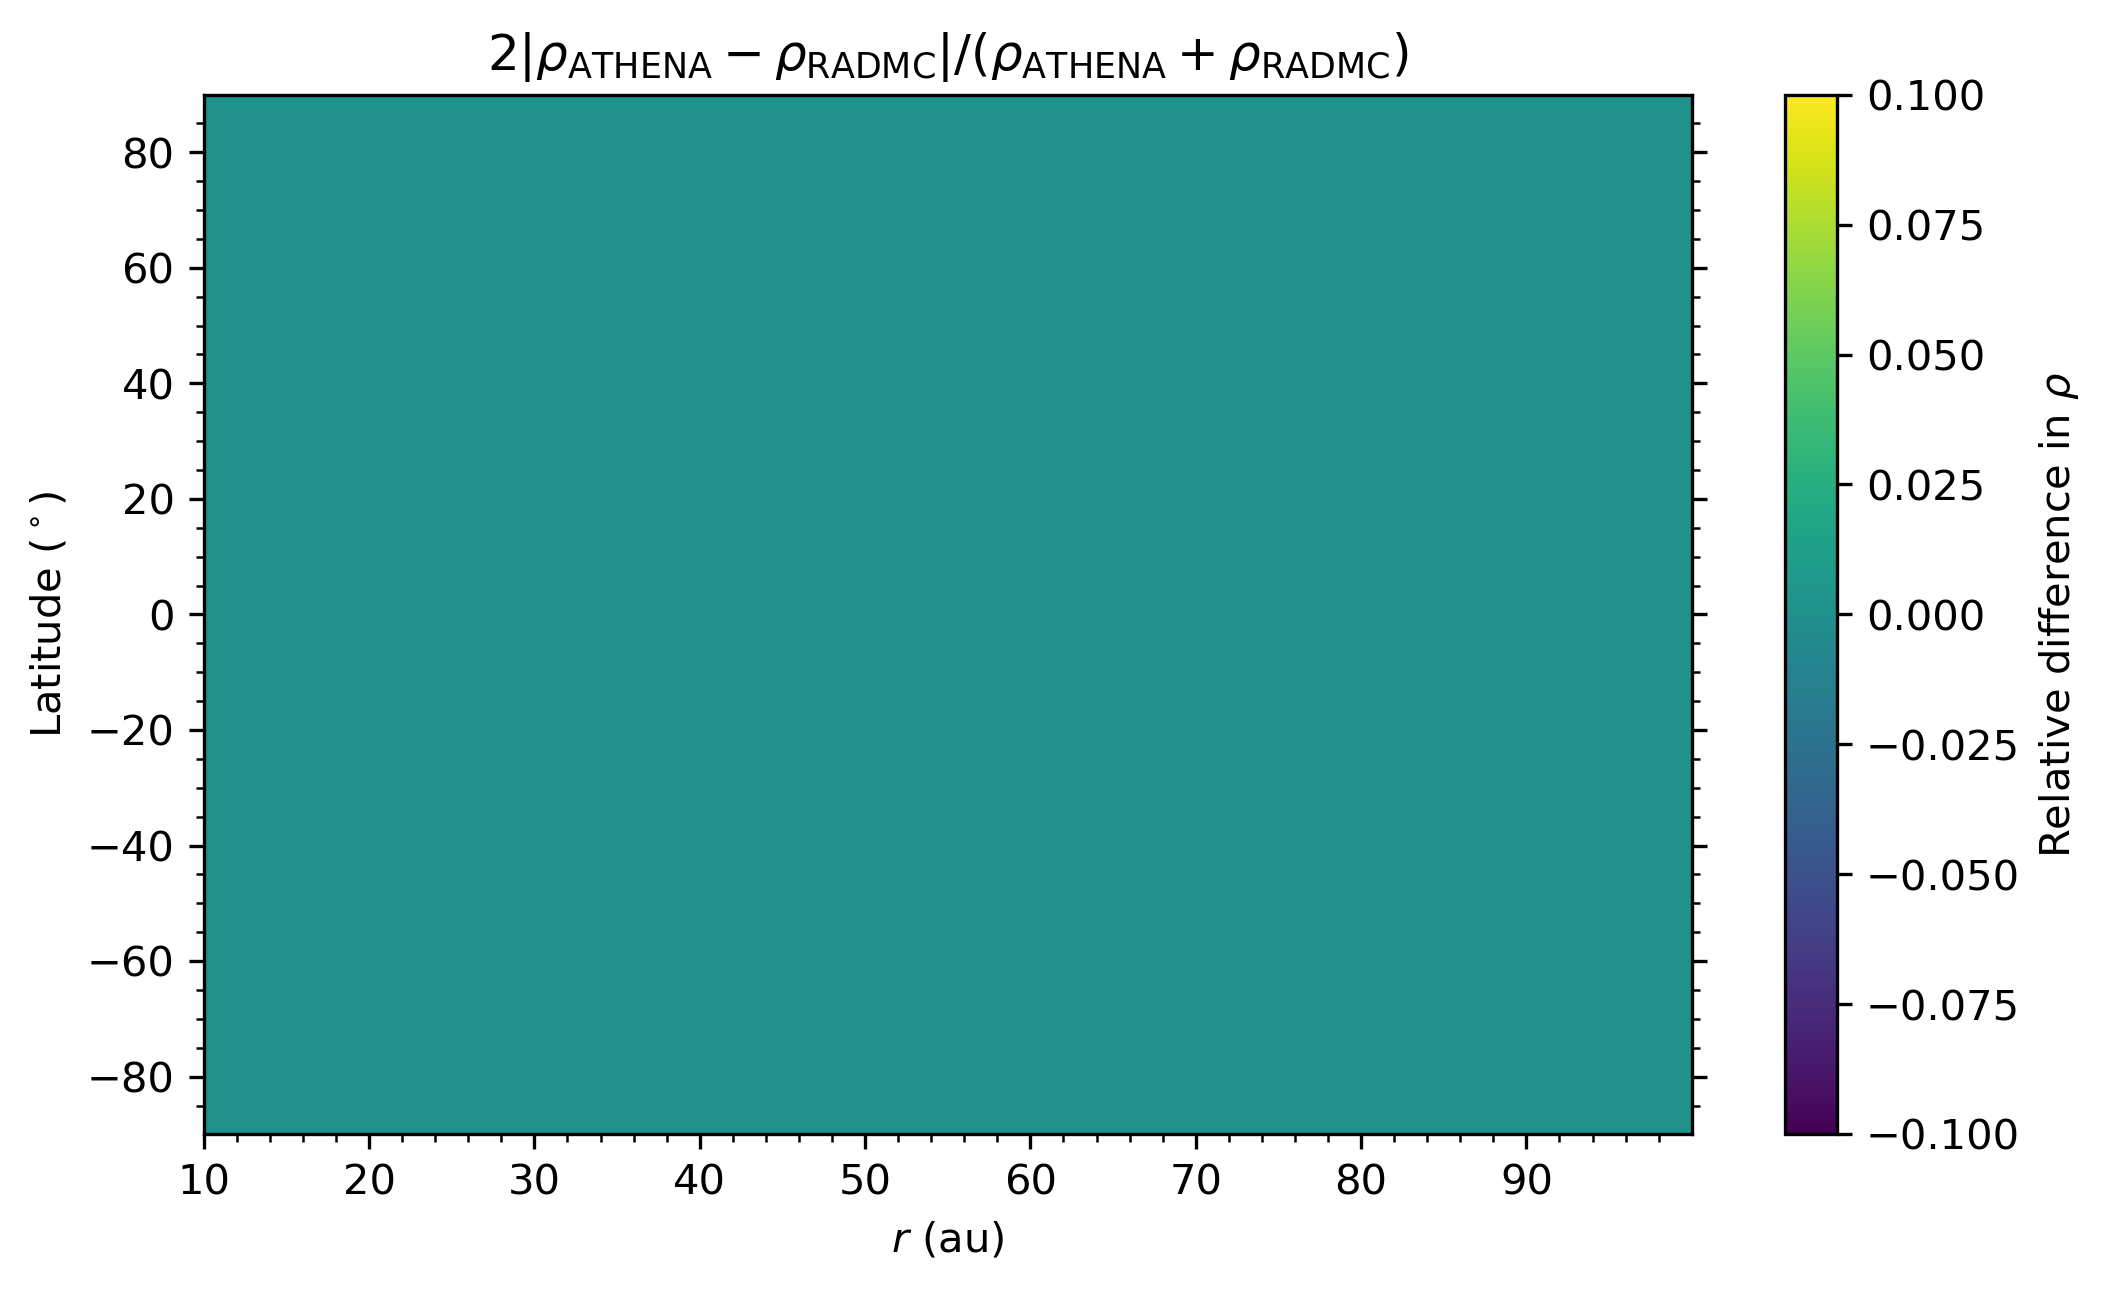

In [4]:
#===============================================================================
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
from radmc3dPy import *
import sys
sys.path.insert(0, '/home/stanley/github/PrincetonUniversity/athena/vis/python')
import athena_read

# Constants, units, conversions
rad2deg = 180/np.pi      # [deg]
au      = 1.495978707e13 # astronomical unit [cm]

# RADMC-3D
data = analyze.readData(ddens=True)

# Athena++
run = 'nfreq/4'
problem_id = 'dsharp'
path = '/home/stanley/github/sabaronett/rad-hydro/athena/dev/yanfeij/'\
       +f'{problem_id}_abs-v3/{run}'
athinput = athena_read.athinput(f'{path}/athinput.{problem_id}')
athdf = athena_read.athdf(f'{path}/athdf/{problem_id}.out1.00000.athdf')
length_unit = athinput['radiation']['length_unit']
L_au = length_unit/au
density_unit = athinput['radiation']['density_unit']

# Plot
fig, ax = plt.subplots(figsize=(8, 4.5), dpi=300)
drho = athdf['rho'][0]*density_unit - data.rhodust[:,:,0,0].T
srho = athdf['rho'][0]*density_unit + data.rhodust[:,:,0,0].T
rel_diff = 2*np.abs(drho)/srho
im = ax.pcolormesh(athdf['x1v']*L_au, 90-athdf['x2v']*rad2deg, rel_diff)

# Format (sub)plots
plt.colorbar(im, label=r'Relative difference in $\rho$')
ax.minorticks_on()
ax.set(xlabel='$r$ (au)', ylabel=r'Latitude ($^\circ$)',
       title=r'$2|\rho_\mathrm{ATHENA} - \rho_\mathrm{RADMC}|$'\
                       +r'$/(\rho_\mathrm{ATHENA} + \rho_\mathrm{RADMC})$')
ax.tick_params(axis='both', which='both', right=True)

## Output Analysis

### DSHARP Opacities

- Birnstiel et al. ([2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...869L..45B/abstract))
- (From Shangjia Zhang)
  - 30% water
  - Carbon?

Reading dustkappa_dsharp.inp


[None,
 None,
 Text(0.5, 0, '$\\mathrm{\\lambda}$ ($\\mathrm{\\mu}$m)'),
 Text(0, 0.5, '$\\kappa_\\nu$ (cm$^2$ g$^{-1}$)'),
 (1e-15, 100000.0),
 Text(0.5, 1.0, 'DSHARP ($a_\\mathrm{max}=1\\,\\mathrm{\\mu m}, q=3.5$)')]

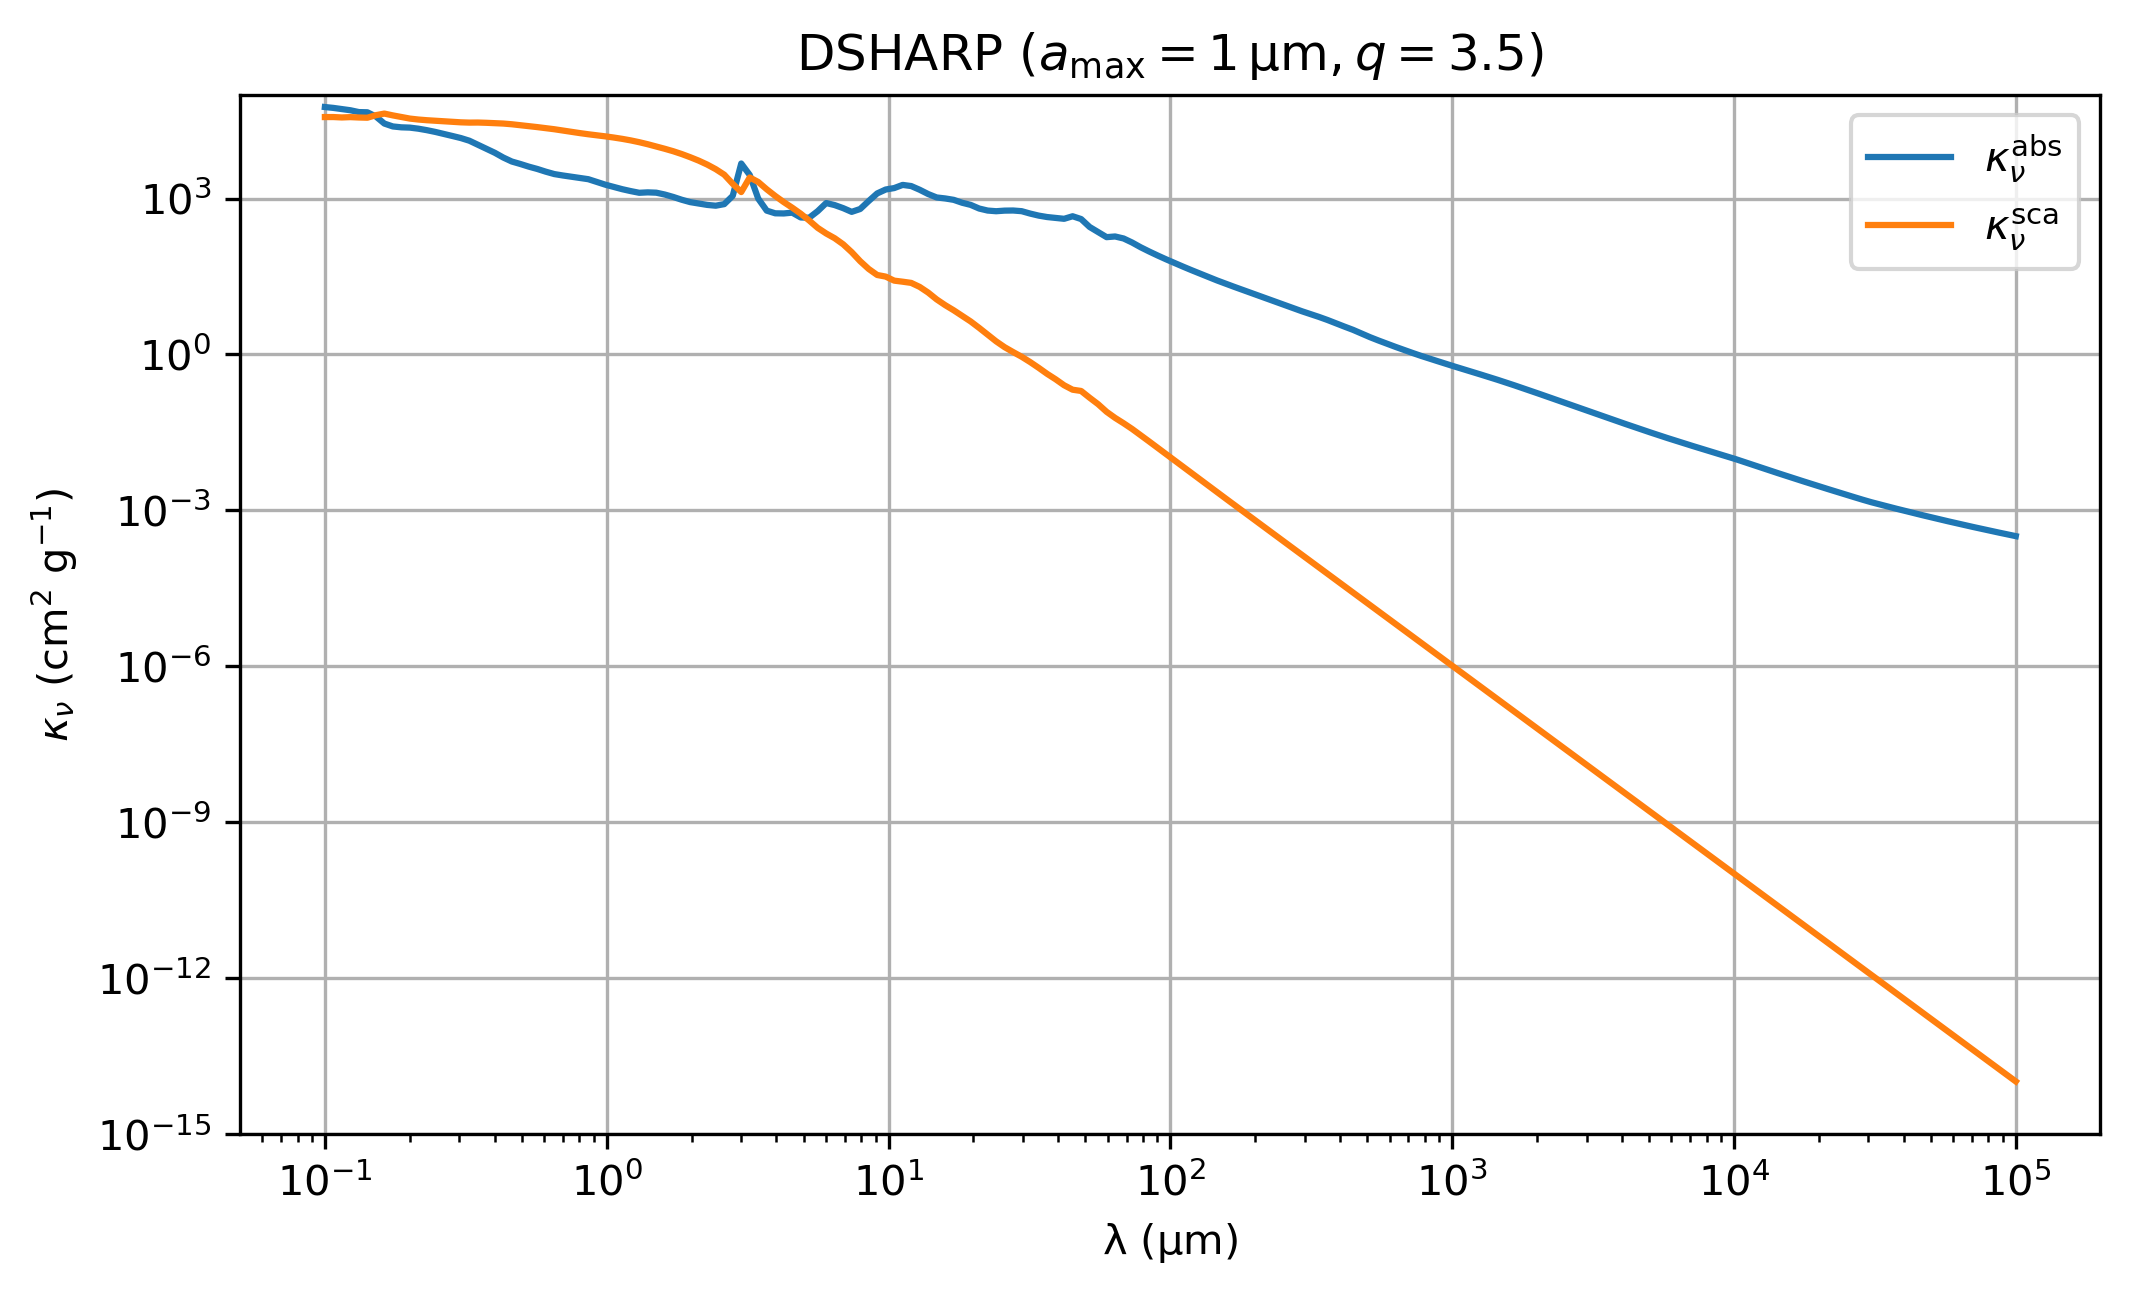

In [5]:
#===============================================================================
import matplotlib.pyplot as plt
import numpy as np
from radmc3dPy import analyze # execute cell twice
from radmc3dPy.natconst import *

# Plot absorption coefficient as a function of wavelength
opac   = analyze.readOpac(ext=['dsharp']) #https://www.ita.uni-heidelberg.de/~dullemond/software/radmc-3d/manual_rmcpy/radmc3dPy.html?highlight=radmc3ddustopac#radmc3dPy.dustopac.radmc3dDustOpac
# figsize = (4, 3)
figsize = (8, 4.5)
fig, ax = plt.subplots(figsize=figsize, dpi=300)

ax.plot(opac.wav[0], opac.kabs[0], label=r'$\kappa_\nu^\mathrm{abs}$')
ax.plot(opac.wav[0], opac.ksca[0], label=r'$\kappa_\nu^\mathrm{sca}$')
ax.grid()
ax.legend()
ax.minorticks_on()
ax.set(xscale='log', yscale='log', xlabel=r'$\mathrm{\lambda}$ ($\mathrm{\mu}$m)',
       ylabel=r'$\kappa_\nu$ (cm$^2$ g$^{-1}$)', ylim=(1e-15, 1e5),
       title=r'DSHARP ($a_\mathrm{max}=1\,\mathrm{\mu m}, q=3.5$)')

Reading dustkappa_dsharp.inp


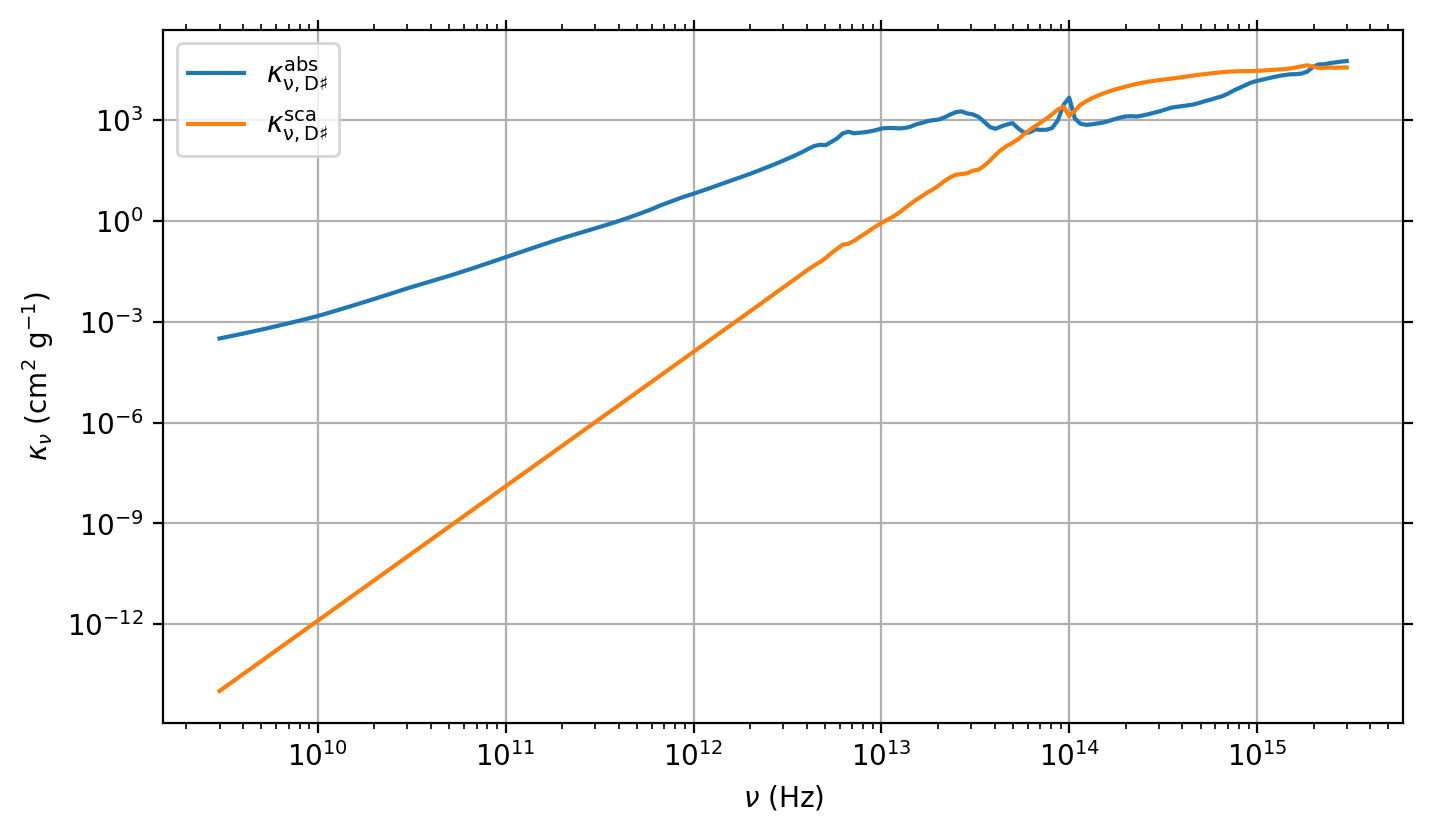

In [6]:
#===============================================================================
from radmc3dPy import analyze # execute cell twice
from radmc3dPy.natconst import *
from scipy.constants import c, h, k

# Convert constants from SI to cgs
c *= 1e2

# Plot absorption coefficient as a function of wavelength
opac = analyze.readOpac(ext=['dsharp'])
fig, ax = plt.subplots(figsize=(8, 4.5), dpi=200)
opac_freq = np.flip(1e4*c/opac.wav[0])
opac_kabs = np.flip(opac.kabs[0])
opac_ksca = np.flip(opac.ksca[0])

ax.plot(opac_freq, opac_kabs, label=r'$\kappa_\mathrm{\nu,D\sharp}^\mathrm{abs}$')
ax.plot(opac_freq, opac_ksca, label=r'$\kappa_\mathrm{\nu,D\sharp}^\mathrm{sca}$')
ax.grid()
ax.legend()
ax.minorticks_on()
ax.set(xlabel=r'$\nu$ (Hz)',
       ylabel=r'$\kappa_\nu$ (cm$^2$ g$^{-1}$)',
       xscale='log', yscale='log')
ax.tick_params(axis='both', which='both', top=True, right=True)

Reading amr_grid.inp
Reading wavelength_micron.inp
Reading dust_density.inp
Reading dust_temperature.dat
Reading dustkappa_dsharp.inp
Opacity at 0.88um :  19233.939524821228


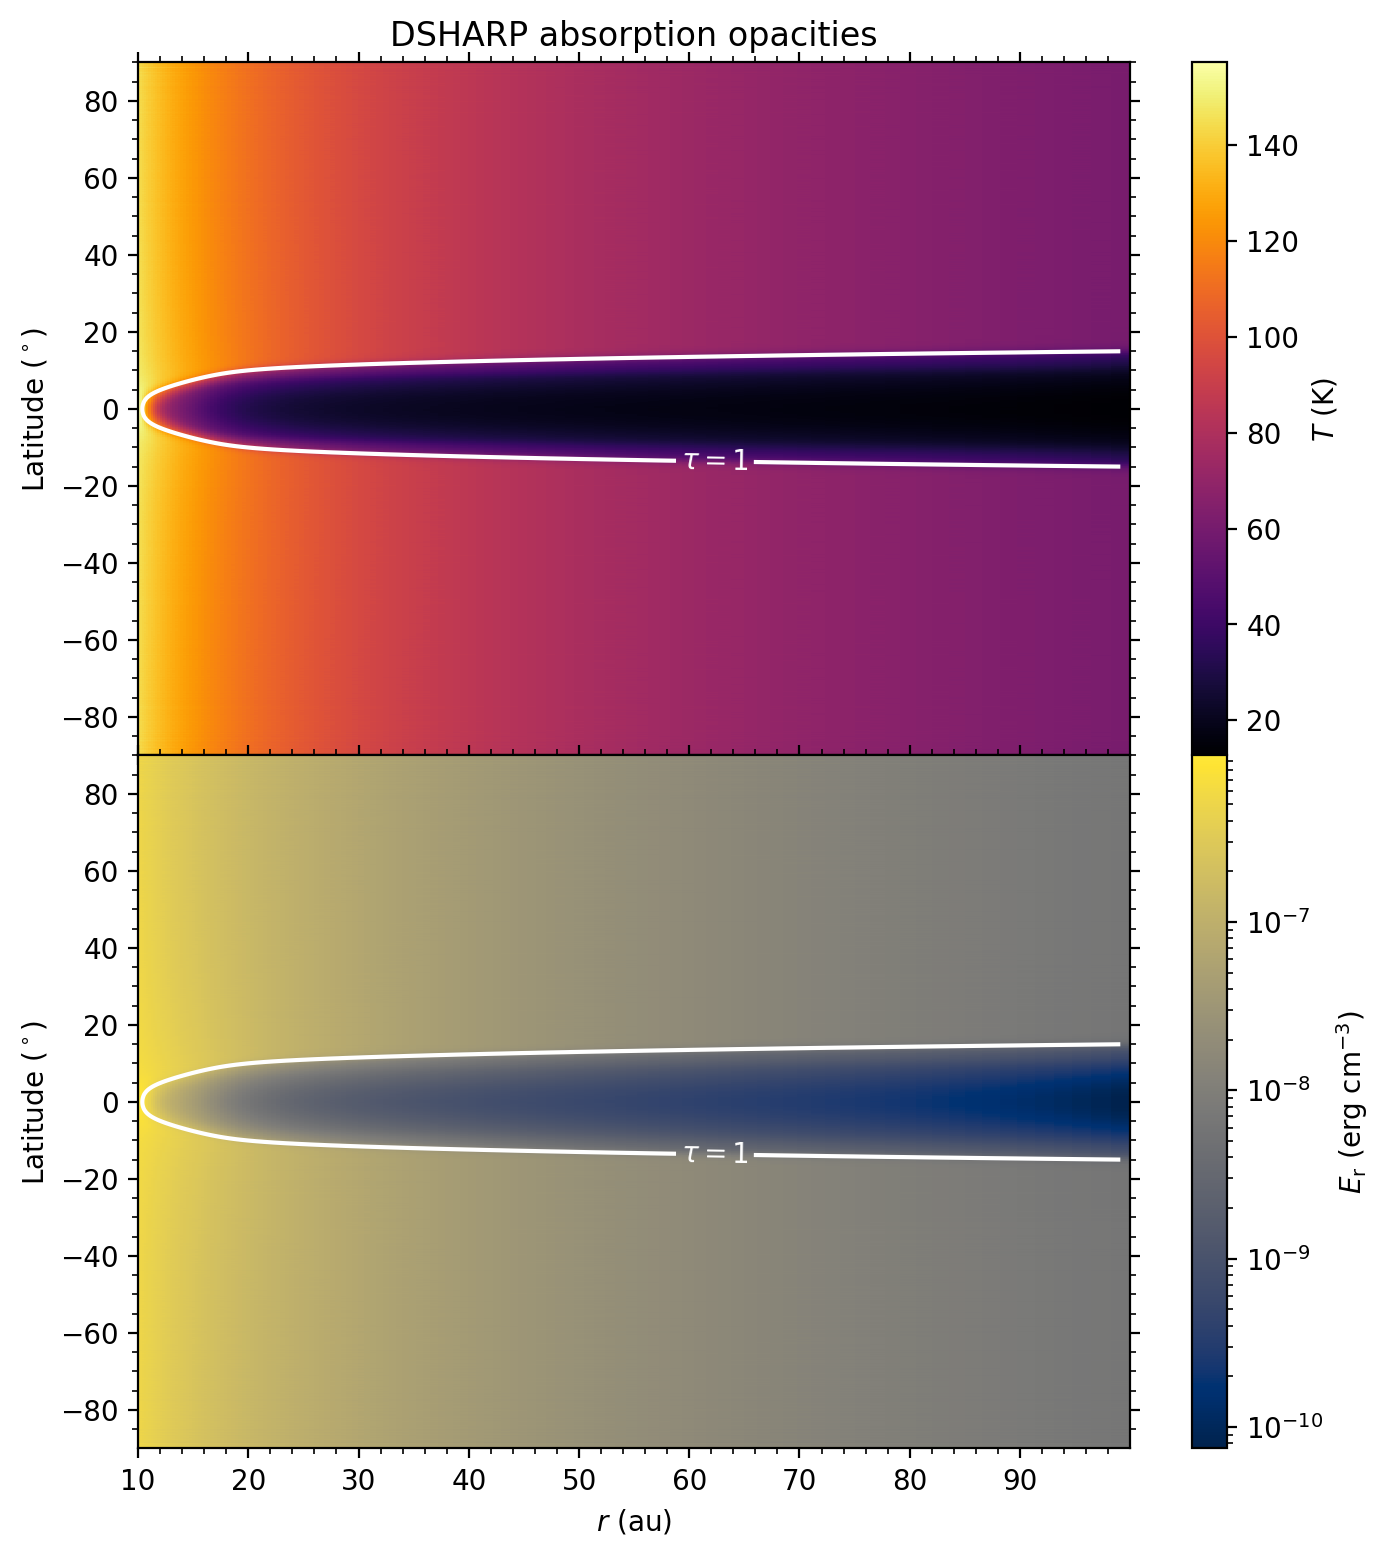

In [7]:
#===============================================================================
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
from radmc3dPy import *

# Conversions
rad2deg = 180/np.pi # [deg]

# Prepare plots
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(8, 9), dpi=200)
def fmt(x):
    return rf'$\tau={x:.0f}$'

# RADMC-3D
data = analyze.readData(ddens=True, dtemp=True)
np.savez_compressed('amr_grid', grid=data.grid)
np.savez_compressed('dust_density', rhodust=data.rhodust)
data.getTau(wav=0.88)
np.savez_compressed('taux', taux=data.taux)
np.savez_compressed('dust_temperature', dusttemp=data.dusttemp)
im0 = axs[0].pcolormesh(data.grid.x/natconst.au, 90-data.grid.y*rad2deg,
                        data.dusttemp[:,:,0,0].T, cmap='inferno')
totmeanint = np.load('total_mean_intensity.npz')['totmeanint']
Er = 4*np.pi*totmeanint[:,:,0]/natconst.cc
im1 = axs[1].pcolormesh(data.grid.x/natconst.au, 90-data.grid.y*rad2deg,
                        Er.T, cmap='cividis', norm=colors.LogNorm())

# Format (sub)plots
axs[0].set(title='DSHARP absorption opacities')
axs[1].set(xlabel='$r$ (au)')
plt.colorbar(im0, label=r'$T$ (K)')
plt.colorbar(im1, label=r'$E_\mathrm{r}$ (erg cm$^{-3}$)')
plt.subplots_adjust(hspace=0.0)
for ax in axs:
    CS = ax.contour(data.grid.x/natconst.au, 90-data.grid.y*rad2deg,
                    data.taux[:,:,0].T, [1, 1e5], colors=['w', 'w'])
    ax.clabel(CS, CS.levels, fmt=fmt)
    ax.minorticks_on()
    ax.set(ylabel=r'Latitude ($^\circ$)')
    ax.tick_params(axis='both', which='both', top=True, right=True)

Reading amr_grid.inp
Reading wavelength_micron.inp
Reading dust_temperature.dat


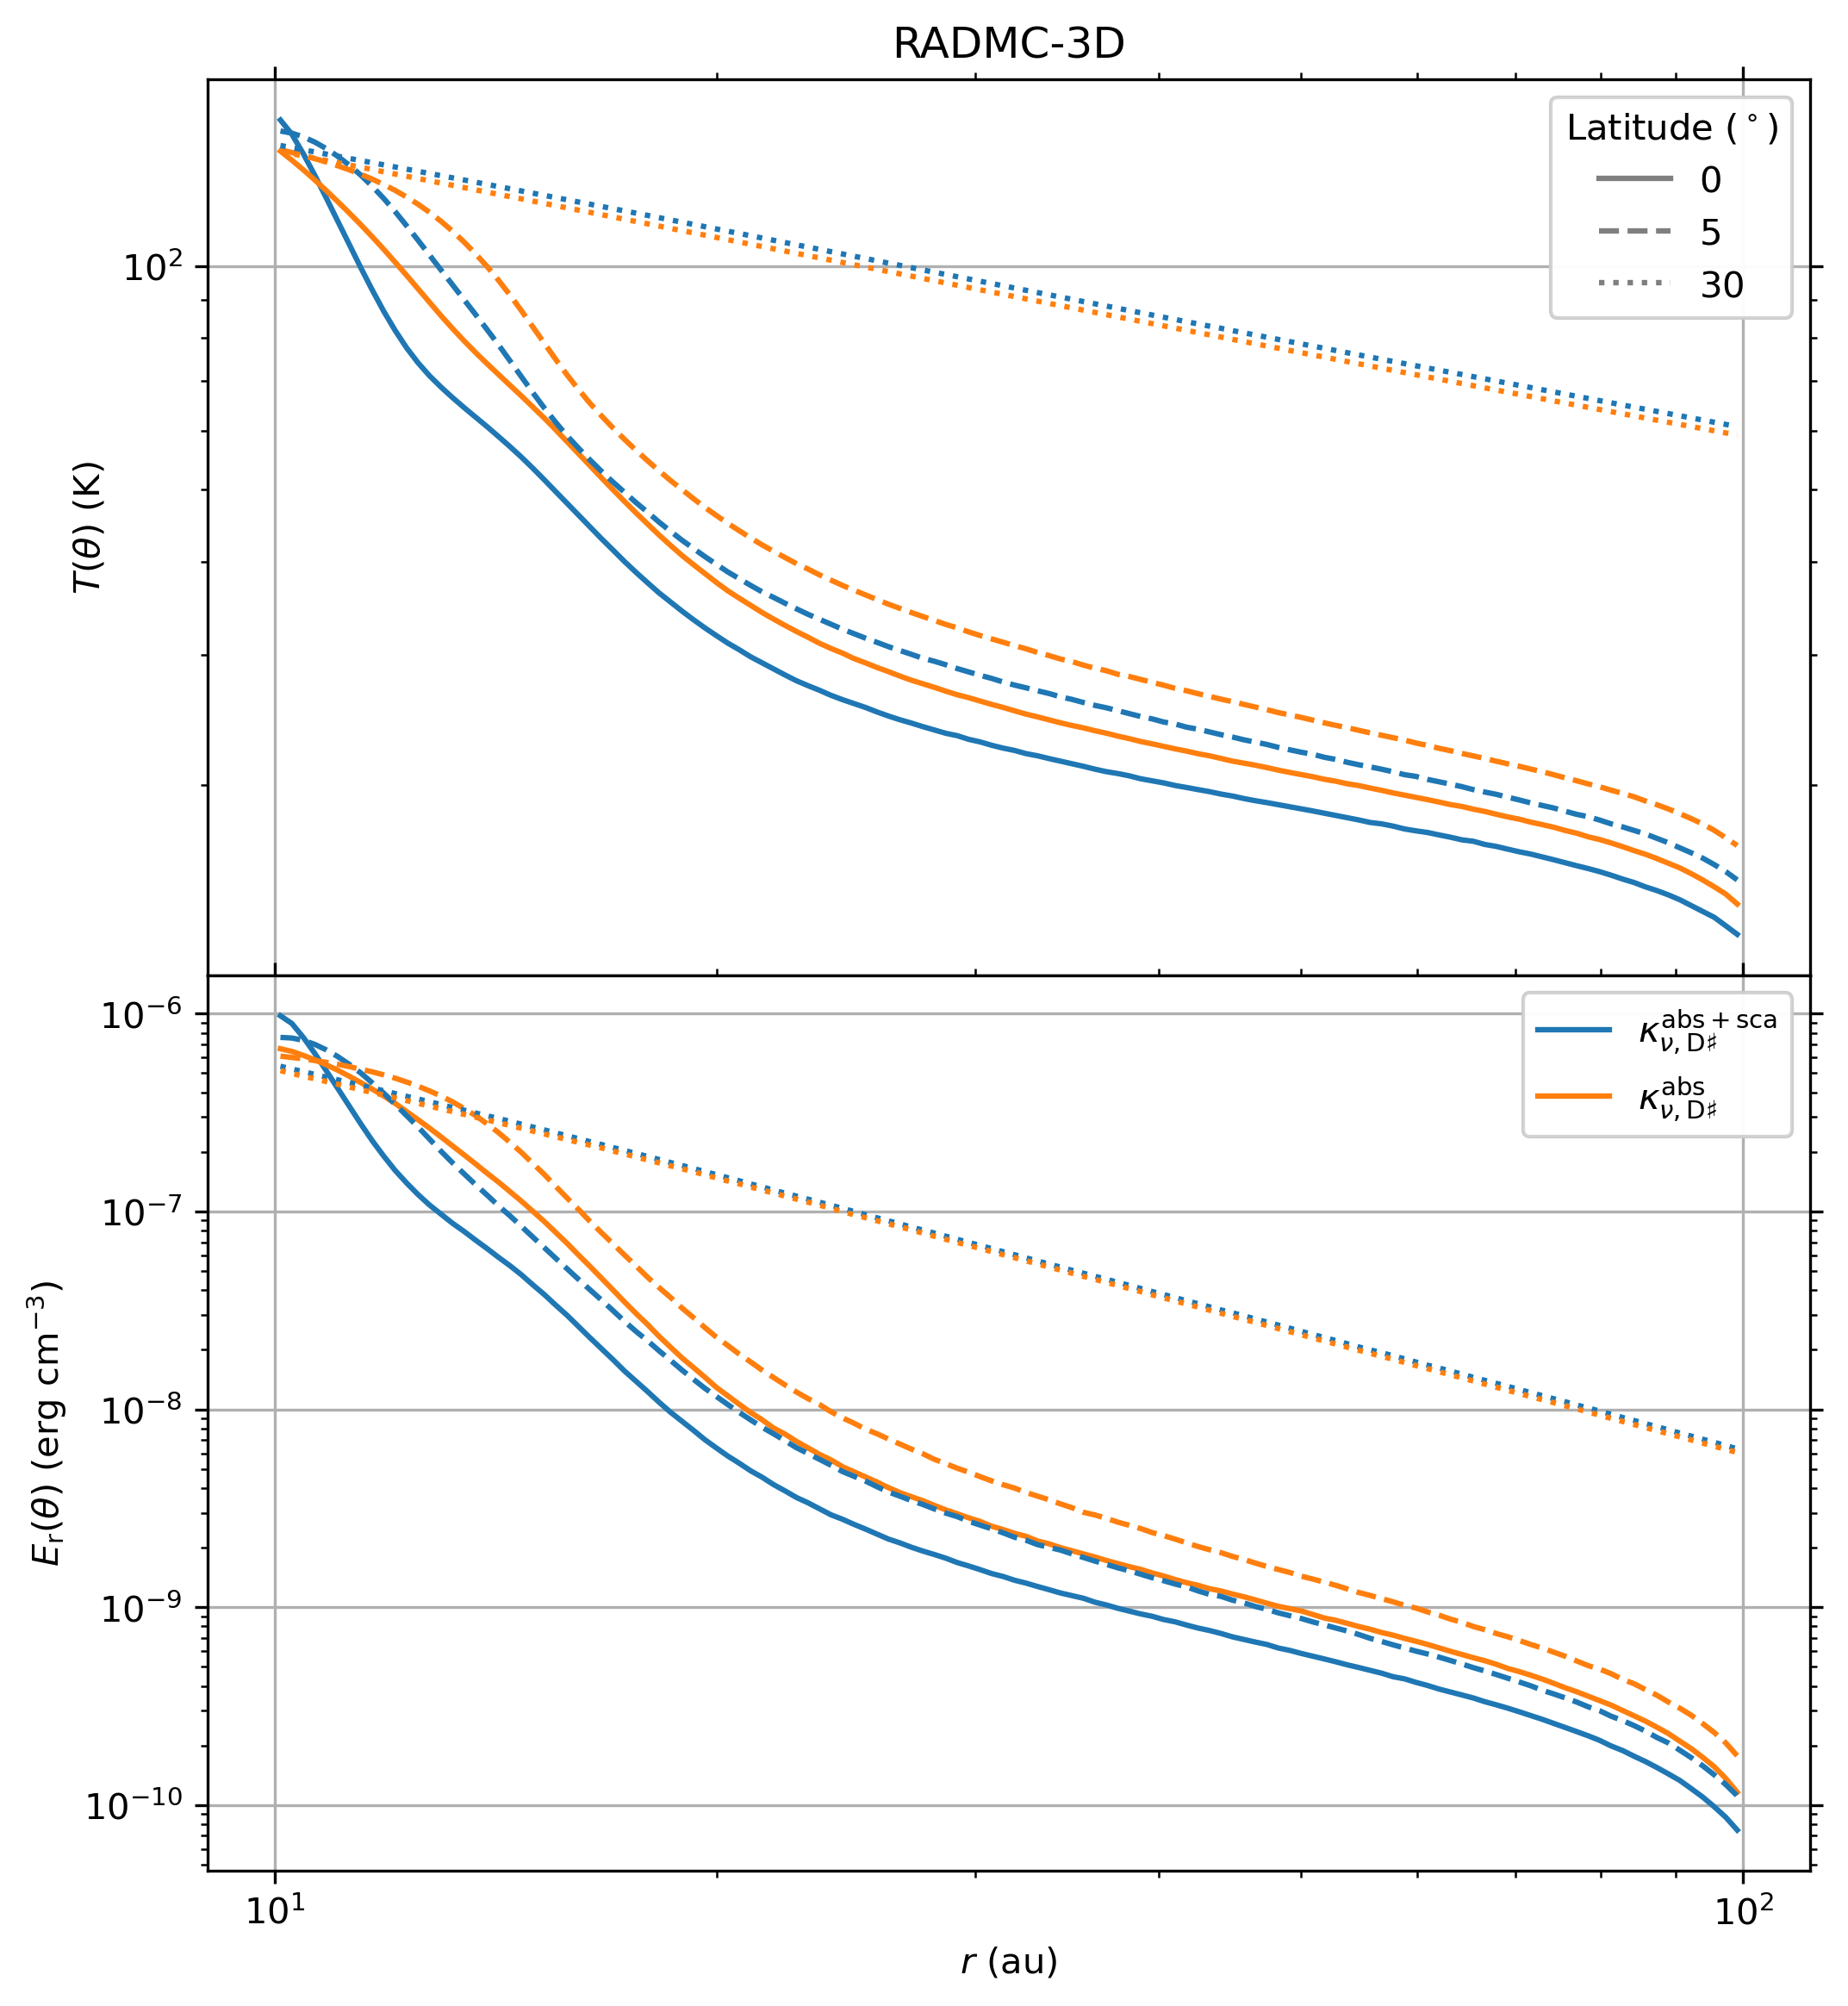

In [13]:
#===============================================================================
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(8, 9), dpi=300)
tab_colors = ['tab:red', 'tab:orange', 'tab:green', 'tab:blue', 'tab:purple',
              'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
theta_degs = [90, 85, 60]
lss = ['solid', 'dashed', 'dotted', 'dashdot']
ls_thetas, c_solns = [], []

# Read and plot solutions
dusttemp_abs = np.load('../dsharp_abs/dust_temperature.npz')['dusttemp']
totmeanint_abs = np.load('../dsharp_abs/total_mean_intensity.npz')['totmeanint']
Er_abs = 4*np.pi*totmeanint_abs[:,:,0]/c_speed
data = analyze.readData(dtemp=True)
totmeanint = np.load('total_mean_intensity.npz')['totmeanint']
Er = 4*np.pi*totmeanint[:,:,0]/natconst.cc
dtheta = (data.grid.y[-1] - data.grid.y[0])/len(data.grid.y)
# np.savez_compressed('dust_temperature_const', dusttemp=data.dusttemp)
for th, theta_deg in enumerate(theta_degs):
    j = int(theta_deg/rad2deg/dtheta)
    axs[0].plot(data.grid.x/natconst.au, data.dusttemp[:,j,0,0],
                color='tab:blue', ls=lss[th])
    axs[0].plot(data.grid.x/natconst.au, dusttemp_abs[:,j,0,0],
                color='tab:orange', ls=lss[th])
    axs[1].plot(data.grid.x/natconst.au, Er[:,j], color='tab:blue', ls=lss[th])
    axs[1].plot(data.grid.x/natconst.au, Er_abs[:,j], color='tab:orange',
                ls=lss[th])
    ls_thetas.append(axs[0].plot([], [], color='tab:gray', ls=lss[th],
                     label=rf'${90-theta_deg}$')[0])

# Plot ghost points for colorless line style and add legends
ls_legend = axs[0].legend(title=r'Latitude ($^\circ$)', handles=ls_thetas)
axs[0].add_artist(ls_legend)
c_solns.append(axs[1].plot([], [], color='tab:blue',
               label=r'$\kappa_{\nu,\mathrm{D}\sharp}^\mathrm{abs+sca}$')[0])
c_solns.append(axs[1].plot([], [], color='tab:orange',
               label=r'$\kappa_{\nu,\mathrm{D}\sharp}^\mathrm{abs}$')[0])
color_legend = axs[1].legend(handles=c_solns)
axs[1].add_artist(color_legend)

# Format (sub)plots
plt.subplots_adjust(hspace=0.0)
axs[0].set(ylabel=r'$T(\theta)$ (K)', title='RADMC-3D')
axs[1].set(xlabel=r'$r$ (au)', ylabel=r'$E_\mathrm{r}(\theta)$ (erg cm$^{-3}$)')
for ax in axs:
    ax.grid()
    ax.minorticks_on()
    ax.set(xscale='log', yscale='log')
    ax.tick_params(axis='both', which='both', top=True, right=True)